<h1>Intent recognition</h1>
This file is dedicated to finding the intent of a phase giving to it.

<h2>Data Collection</h2>
<ul>
    <li>
        The following codes below in this section is dedicated to defining a tokenizer to pass our text into and a class fro which the data will be passed into.
    </li>
    <li>
        We also import all necessary modules in this section as well.
    </li>
    <li>
        Data was made by me and reading up on some articles on the internet listed below
        <br>
           <a>https://www.seattletimes.com/business/sarah-li-cain-15-best-questions-to-ask-when-buying-a-house/</a>
        <br>
           <a> https://blog.carousell.com/property/house-viewing-tips-singapore/</a>
    </li>

In [ ]:
#USED COLAB TO RUN CODE SO MIGHT NOT WORK

#Necessary Imports
!pip install transformers

from transformers import DistilBertTokenizerFast, BertConfig, DistilBertTokenizer, DistilBertModel, DistilBertConfig, DistilBertForSequenceClassification
from transformers import AlbertTokenizerFast, AlbertConfig, AlbertModel, AlbertForSequenceClassification 
from transformers import Trainer, TrainingArguments
import torch
import pandas as pd
import numpy as np


In [ ]:

#Tokenizer to be used to tokenize data into word indexes
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2',do_lower_case=True)
tokenizer2 = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

#Class to pass dataset into model for training
class SentenceClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def train_test_split_alt(x, y, train_samples=4, test_samples=1):

    # This is the split train/test x/y
    train_x = []
    train_y = []
    test_x = []
    test_y = []

    # Loop through every sample and begin to split by bunches
    #
    for i in range(len(x)):

        # The modulo operator (%) is the one that helps 
        # break up our samples into bunches of (m + n)
        #
        if i % (train_samples + test_samples) < train_samples:
            # The first m samples in our bunch goes into the
            # training set
            #
            train_x.append(x[i])
            train_y.append(y[i])

        else:
            # The next n samples in our bunch goes into the
            # test set
            #
            test_x.append(x[i])
            test_y.append(y[i])
      
    # Finally, return the results in the same form as Scikit-learn's
    # train_test_split function
    #
    return train_x, test_x, train_y, test_y

def load_csv_into_input_text_and_labels(filepath, input_column, output_column):

    df = pd.read_csv(filepath)
    input = df[input_column]
    output = df[output_column]
    return input, output


    
all_texts, all_labels = load_csv_into_input_text_and_labels("chatbot_intents.csv", "Text", "Label")

loading file https://huggingface.co/albert-base-v2/resolve/main/spiece.model from cache at /root/.cache/huggingface/transformers/10be6ce6d3508f1fdce98a57a574283b47c055228c1235f8686f039287ff8174.d6110e25022b713452eb83d5bfa8ae64530995a93d8e694fe52e05aa85dd3a7d
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/828a43aa4b9d07e2b7d3be7c6bc10a3ae6e16e8d9c3a0c557783639de9eaeb1b.670e237d152dd53ef77575d4f4a6cd34158db03128fe4f63437ce0d5992bac74
loading file https://huggingface.co/albert-base-v2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/albert-base-v2/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c

<h1>Data Preparation</h1>
<ul>
    <li>
        Create list of all unique labels
    </li>
    <li>
        Split data into training and validation
    </li>
    <li>
        Encode data
    </li>
</ul>

In [ ]:
sentence_labels = ["goodbye",
                   "greeting",
                   "house_age",
                   "house_area",
                   "description",
                   "price",
                   "sale_period",
                   "sale_reason",
                   "viewing"]

#mapping of labels to an index
sentence_labels_id_by_label = dict((t, i) for i, t in enumerate(sentence_labels))

print (sentence_labels)
print (sentence_labels_id_by_label)

['goodbye', 'greeting', 'house_age', 'house_area', 'description', 'price', 'sale_period', 'sale_reason', 'viewing']
{'goodbye': 0, 'greeting': 1, 'house_age': 2, 'house_area': 3, 'description': 4, 'price': 5, 'sale_period': 6, 'sale_reason': 7, 'viewing': 8}


<h1>Training Model- Classification</h1>
<ul>
    <li>
        Split data into training and validation
    </li>
    <li>
        Encode data
    </li>
</ul>
</li>


In [ ]:
#Load CSV into 2 variables, all_texts and all_labels
all_texts, all_labels = load_csv_into_input_text_and_labels("chatbot_intents.csv", "Text", "Label")

#Split data in a 4:1 ratio (training:validation)
train_texts, val_texts, train_labels, val_labels = train_test_split_alt(all_texts, all_labels, 7, 3)

print(val_labels)
#Convert label into corresponding index
train_labels = [sentence_labels_id_by_label[label] if label in sentence_labels_id_by_label else 0 for label in train_labels]
val_labels = [sentence_labels_id_by_label[label] if label in sentence_labels_id_by_label else 0 for label in val_labels]

#ALBERT Model
#Convert text into word indexes and attention masks 
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

#Construct dataset from the encodings above
train_dataset = SentenceClassificationDataset(train_encodings, train_labels)
val_dataset = SentenceClassificationDataset(val_encodings, val_labels)

#BERT Model
#Convert text into word indexes and attention masks 
train_encodings2 = tokenizer2(train_texts, truncation=True, padding=True)
val_encodings2 = tokenizer2(val_texts, truncation=True, padding=True)

#Construct dataset from the encodings above
train_dataset2 = SentenceClassificationDataset(train_encodings2, train_labels)
val_dataset2 = SentenceClassificationDataset(val_encodings2, val_labels)

['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'house_area', 'house_area', 'house_area', 'house_area', 'house_area', 'house_area', 'house_area', 'house_area', 'house_area', 'sale_reason', 'sale_reason', 'sale_reason', 'sale_reason', 'sale_reason', 'sale_reason', 'sale_reason', 'sale_period', 'sale_period', 'sale_period', 'sale_period', 'sale_period', 'sale_period', 'sale_period', 'sale_period', 'house_age', 'house_age', 'house_age', 'house_age', 'house_age', 'house_age', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'description', 'viewing', 'viewing', 'viewing', 'viewing', 'viewing', 'viewing', 'viewing', 'viewing', 'viewing', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'price', 'price', 'price']


In [ ]:
print(train_labels)
print(val_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5]


<h2>ALBERT</h2>
<ul>
    <li>
        We will use ALBERT for this section
    </li>
    <li>
        A Lite BERT that presents two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT
    </li>
</ul>

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

intent_classification_model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(sentence_labels))

trainer = Trainer(
    model=intent_classification_model,   # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

#save the model
torch.save(intent_classification_model, "intentclassification.model")




PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",

Step,Training Loss
10,2.401000
20,2.338600
30,2.187300
40,2.197700
50,2.103000
60,2.060900
70,2.007800
80,1.920700
90,1.968300
100,1.714500




Training completed. Do not forget to share your model on huggingface.co/models =)




(9, 9)
             goodbye  greeting  house_age  ...  sale_period  sale_reason  viewing
goodbye            9         0          0  ...            0            0        0
greeting           4         2          0  ...            0            0        0
house_age          0         0          2  ...            4            0        0
house_area         0         0          0  ...            0            0        0
description        0         0          0  ...            2            0        1
price              0         0          0  ...            0            0        0
sale_period        0         0          0  ...            7            0        0
sale_reason        0         0          0  ...            0            7        0
viewing            0         0          0  ...            0            1        7

[9 rows x 9 columns]


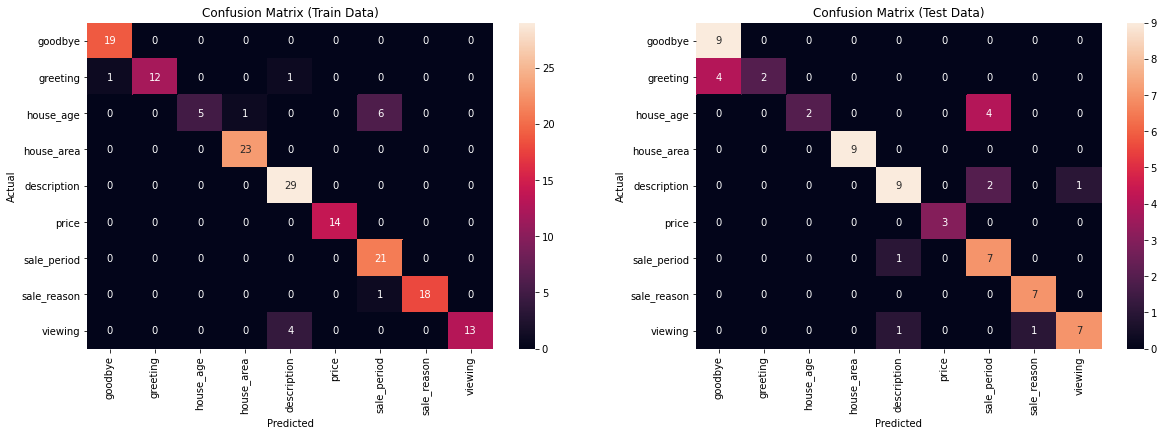

Train Data
--------------------------------------------------------
              precision    recall  f1-score   support

     goodbye       0.95      1.00      0.97        19
    greeting       1.00      0.86      0.92        14
   house_age       1.00      0.42      0.59        12
  house_area       0.96      1.00      0.98        23
 description       0.85      1.00      0.92        29
       price       1.00      1.00      1.00        14
 sale_period       0.75      1.00      0.86        21
 sale_reason       1.00      0.95      0.97        19
     viewing       1.00      0.76      0.87        17

    accuracy                           0.92       168
   macro avg       0.95      0.89      0.90       168
weighted avg       0.93      0.92      0.91       168


Test Data
--------------------------------------------------------
              precision    recall  f1-score   support

     goodbye       0.69      1.00      0.82         9
    greeting       1.00      0.33      0.50       

In [ ]:
def infer_intent(text):
    
    # Passes the text into the tokenizer
    #
    input = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to("cuda")
    #print (input)

    # Sends the result from the tokenizer into our classification model
    #
    output = intent_classification_model(**input, return_dict=True)

    # Extract the output logits of the one and only input text.
    # The logits contains the output from the last layer but without 
    # softmax applied. 
    # 
    output = output.logits[0].to("cpu").detach().numpy()
    
    # Find the classification index with the highest value.
    #  
    label_index = np.argmax(output)

    # Remove all the memory used by CUDA for the inference
    #
    del input
    del output
    torch.cuda.empty_cache()

    # Return the result to the caller
    #
    return label_index

# Use the model to infer intents for the entire training and validation
# dataset.
#
actual_y_train = train_labels
actual_y_test = val_labels
pred_y_train = [infer_intent(text) for text in train_texts]
pred_y_test = [infer_intent(text) for text in val_texts]

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def display_model_evaluation_results(y_train, pred_y_train, y_test, pred_y_test, labels):
    
    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train, pred_y_train)
    print (cm.shape)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test, pred_y_test)
    
    cm_df = pd.DataFrame(cm, labels, labels)  
    print(cm_df)        
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data")
    print ("--------------------------------------------------------")
    print(classification_report(y_train, pred_y_train, target_names=labels))
    print ("")
    print ("Test Data")
    print ("--------------------------------------------------------")
    print(classification_report(y_test, pred_y_test, target_names=labels))


display_model_evaluation_results(actual_y_train, pred_y_train, actual_y_test, pred_y_test, sentence_labels)


<h2>DistilBERT</h2>
<ul>
    <li>
        We will use DistilBERT for this section.
    </li>
    <li>
        A smaller, faster cheaper version of BERT that retrains 95% of BERT's performance as a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia
    </li>
</ul>

In [ ]:

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

intent_classification_model2 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(sentence_labels))

trainer2 = Trainer(
    model=intent_classification_model2,   # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset2,         # training dataset
    eval_dataset=val_dataset2             # evaluation dataset
)

trainer2.train()

#save the model
torch.save(intent_classification_model2, "intentclassification2.model")


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  

Step,Training Loss
10,2.191900
20,2.184200
30,2.204100
40,2.213000
50,2.142800
60,2.161800
70,2.146400
80,2.083100
90,2.082700
100,1.973400




Training completed. Do not forget to share your model on huggingface.co/models =)




(9, 9)
             goodbye  greeting  house_age  ...  sale_period  sale_reason  viewing
goodbye            0         6          0  ...            0            0        0
greeting           0         1          0  ...            1            0        0
house_age          1         0          0  ...            0            2        0
house_area         0         0          0  ...            3            4        0
description        0         0          0  ...            1            4        0
price              0         0          0  ...            0            1        0
sale_period        0         1          0  ...            4            2        0
sale_reason        0         1          0  ...            3            3        0
viewing            0         1          0  ...            0            2        0

[9 rows x 9 columns]


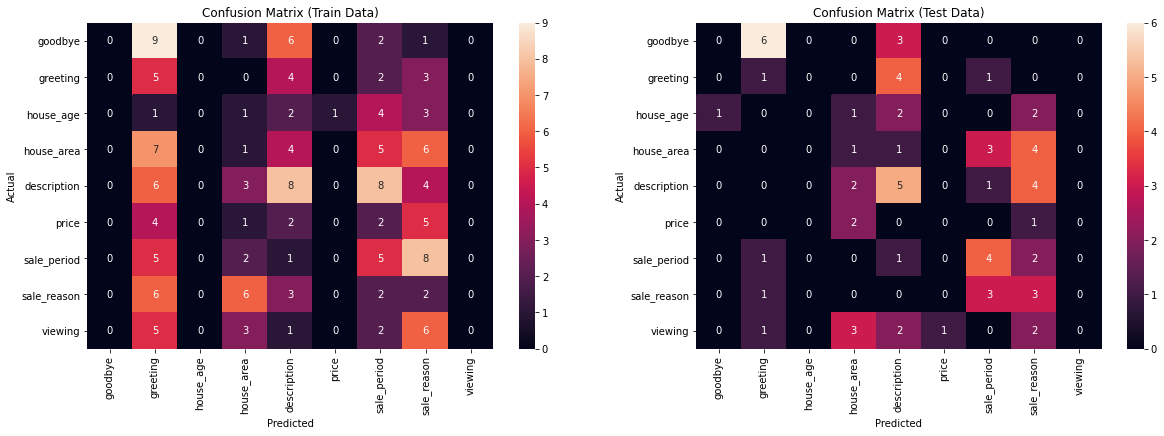

Train Data
--------------------------------------------------------
              precision    recall  f1-score   support

     goodbye       0.00      0.00      0.00        19
    greeting       0.10      0.36      0.16        14
   house_age       0.00      0.00      0.00        12
  house_area       0.06      0.04      0.05        23
 description       0.26      0.28      0.27        29
       price       0.00      0.00      0.00        14
 sale_period       0.16      0.24      0.19        21
 sale_reason       0.05      0.11      0.07        19
     viewing       0.00      0.00      0.00        17

    accuracy                           0.12       168
   macro avg       0.07      0.11      0.08       168
weighted avg       0.09      0.12      0.10       168


Test Data
--------------------------------------------------------
              precision    recall  f1-score   support

     goodbye       0.00      0.00      0.00         9
    greeting       0.10      0.17      0.12       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Define a function to perform inference on a single input text.
# 
def infer_intent2(text):
    
    # Passes the text into the tokenizer
    #
    input = tokenizer2(text, truncation=True, padding=True, return_tensors="pt").to("cuda")
    #print (input)

    # Sends the result from the tokenizer into our classification model
    #
    output = intent_classification_model(**input, return_dict=True)

    # Extract the output logits of the one and only input text.
    # The logits contains the output from the last layer but without 
    # softmax applied. 
    # 
    output = output.logits[0].to("cpu").detach().numpy()
    
    # Find the classification index with the highest value.
    #  
    label_index = np.argmax(output)

    # Remove all the memory used by CUDA for the inference
    #
    del input
    del output
    torch.cuda.empty_cache()

    # Return the result to the caller
    #
    return label_index

# Use the model to infer intents for the entire training and validation
# dataset.
#
actual_y_train2 = train_labels
actual_y_test2 = val_labels
pred_y_train2 = [infer_intent2(text) for text in train_texts]
pred_y_test2 = [infer_intent2(text) for text in val_texts]
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np



display_model_evaluation_results(actual_y_train2, pred_y_train2, actual_y_test2, pred_y_test2, sentence_labels)

<h1>Chosen ML model</h1>
<ul>
    <li>
        ALBERT will be chosen for intent recognition as it produces more favourable results compared to distilBERT
    </li>
    <li>
        Reasons
    </li>
        <ul>
            <li>
                Accuracy is higher than distilBERT
            </li>
        </ul>
</ul>

In [ ]:
intent_model = torch.load("intentclassification.model")

text = input("enter text")

print (sentence_labels[infer_intent(text)])